In [19]:
import torch_geometric

import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp
from torch_geometric_temporal.nn.recurrent import EvolveGCNO

import warnings
warnings.filterwarnings("ignore")

# ref: https://medium.com/stanford-cs224w/fraud-detection-with-gat-edac49bda1a0

#### dataset

In [20]:
# import data 
df_features = pd.read_csv('../data/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("../data/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("../data/elliptic_txs_classes.csv")

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge.drop(0, axis=1, inplace=True)

# check if there are duplicate txId
# print("Number of duplicate txId: ", df_merge.duplicated(subset=['txId']).sum())

# rename column 0 to time_step
df_merge.rename(columns={1: 'time_step'}, inplace=True)
# display(df_merge.head())
# display(df_edges.shape)
edges = df_edges.copy()

# Setup trans ID to node ID mapping
nodes = df_merge['txId'].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Map transction IDs to node Ids
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

# Reformat and convert to tensor
edge_index = np.array(edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# print("shape of edge index is {}".format(edge_index.shape))
node_features = df_merge.drop(['txId'], axis=1).copy()
# print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
all_classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
all_unclassified_idx = node_features['class'].loc[node_features['class']==2].index
all_classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
all_classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# node_features = node_features.drop(columns=[0, 1, 'class'])
# display(node_features.head())
train_classified_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] != 2)].index
test_classified_idx = node_features.loc[(node_features['time_step'] > 34) & (node_features['class'] != 2)].index
# print("train_classified_idx.shape=",train_classified_idx.shape)
# print("test_classified_idx.shape=",test_classified_idx.shape)
# node_features.drop(columns=['time_step'], inplace=True)
temp_node_features = node_features.copy()
node_features.drop(columns=['class'], inplace=True)

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)
# Define labels
labels = df_merge['class'].values

#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

# Do train test split on classified_ids
train_idx = train_classified_idx
test_idx = test_classified_idx

# Create pyG dataset
data_graph = Data(x=node_features_t.float(), edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.long))

# Add in the train and valid idx
data_graph.train_idx = train_idx
data_graph.test_idx = test_idx
data_graph

Data(x=[203769, 166], edge_index=[2, 234355], edge_attr=[234355], y=[203769], train_idx=Index([     3,      9,     10,     11,     16,     17,     25,     27,     29,
           30,
       ...
       136232, 136233, 136234, 136236, 136239, 136241, 136243, 136249, 136250,
       136258],
      dtype='int64', length=29894), test_idx=Index([136276, 136277, 136278, 136279, 136280, 136282, 136285, 136287, 136288,
       136291,
       ...
       203727, 203730, 203736, 203740, 203750, 203752, 203754, 203759, 203763,
       203766],
      dtype='int64', length=16670))

#### EvolveGCN Model and Training

In [21]:
class EvolveGCN(torch.nn.Module):
    def __init__(self, node_features, num_classes):
        super(EvolveGCN, self).__init__()
        self.node_features = node_features
        self.num_classes = num_classes
        self.base_model = EvolveGCNO(self.node_features)
        self.fc = torch.nn.Linear(self.node_features, self.num_classes)

    def forward(self, data):
        out = self.base_model(data.x, data.edge_index, data.edge_attr)
        out = out.float() 
        out = self.fc(out)  
        return out


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
CLASS_WEIGTHS = [0.7,0.3]
def train(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data)
    # out = out.reshape((data.x.shape[0]))
    weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    loss.backward()
    optimizer.step()
    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu())
        precision = precision_score(y.cpu(), pred.cpu())
        recall = recall_score(y.cpu(), pred.cpu())
        return acc, f1, precision, recall

In [24]:
num_features = data_graph.num_node_features
print("num_features=",num_features)

num_features= 166


In [25]:
model = EvolveGCN(num_features, 2).to(device)
num_epochs = 500
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall = test(model, data_graph)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Epoch: 000, Loss: 1.0209, Accuracy: 0.9349, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 010, Loss: 0.3815, Accuracy: 0.9350, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 020, Loss: 0.1928, Accuracy: 0.9154, F1: 0.0524, Precision: 0.0963, Recall: 0.0360
Epoch: 030, Loss: 0.1856, Accuracy: 0.9348, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch: 040, Loss: 0.1676, Accuracy: 0.9061, F1: 0.1928, Precision: 0.2182, Recall: 0.1727
Epoch: 050, Loss: 0.1614, Accuracy: 0.9341, F1: 0.0108, Precision: 0.2143, Recall: 0.0055
Epoch: 060, Loss: 0.1557, Accuracy: 0.9125, F1: 0.1945, Precision: 0.2421, Recall: 0.1625
Epoch: 070, Loss: 0.1515, Accuracy: 0.9180, F1: 0.1254, Precision: 0.2042, Recall: 0.0905
Epoch: 080, Loss: 0.1490, Accuracy: 0.9187, F1: 0.1419, Precision: 0.2258, Recall: 0.1034
Epoch: 090, Loss: 0.1470, Accuracy: 0.9103, F1: 0.2297, Precision: 0.2596, Recall: 0.2059
Epoch: 100, Loss: 0.1453, Accuracy: 0.9091, F1: 0.2533, Precision: 0.2717, Recall: 0.2373
Epoch: 110

Accuracy: 0.9067, F1: 0.3830, Precision: 0.3356, Recall: 0.4460


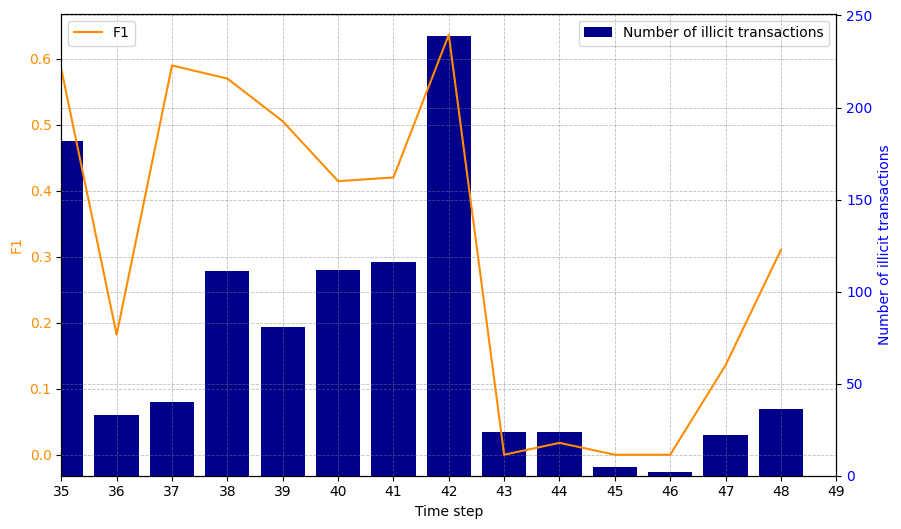

In [26]:
# test 
acc, f1, precision, recall = test(model, data_graph)
print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 49):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='darkblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='darkorange')
ax1.set_xlim(35, 49)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='darkorange')
ax2.set_ylabel('Number of illicit transactions', color='blue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='darkorange')
ax2.tick_params(axis='y', labelcolor='blue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

plt.show()
